### **FINM 33165 (Autumn 2023) - Assignment 2**

* Yumeng Zhang (12372205)
* ymzhang@uchicago.edu

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
from torch.distributions import MultivariateNormal
from torch.distributions.kl import kl_divergence
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
from tqdm import tqdm

#### **Load the MNIST Dataset**

In [2]:
# define data transformation pipeline

transform = transforms.Compose([transforms.ToTensor()]) 

path = './data'

train_dataset = MNIST(path, transform = transform, download = True)
test_dataset = MNIST(path, transform = transform, download = True)

# set up data loaders

batch_size = 100

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

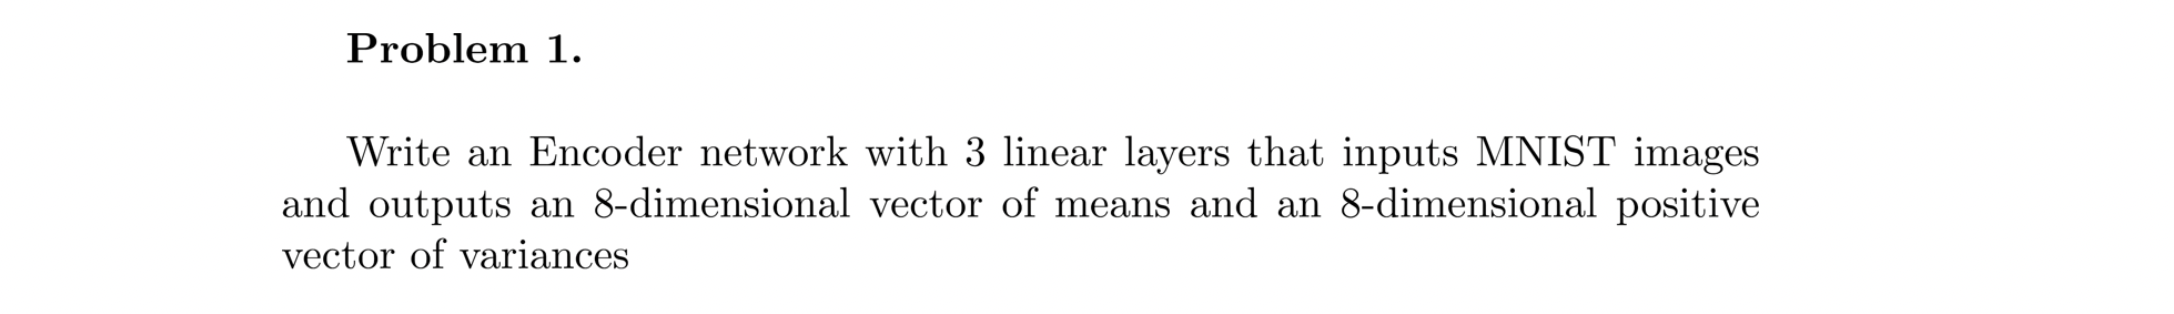

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):

        super().__init__()

        # 1st linear layer
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # 2nd linear layer
        
        self.fc2 = nn.Linear(hidden_dim, latent_dim)

        # 3rd linear layer
        
        self.mean_layer = nn.Linear(latent_dim, 8)      # 8-dimensional
        self.logvar_layer = nn.Linear(latent_dim, 8)      # 8-dimensional
        
    def forward(self,x):
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        logvar = F.softplus(logvar)  # positive
        
        return mean, logvar

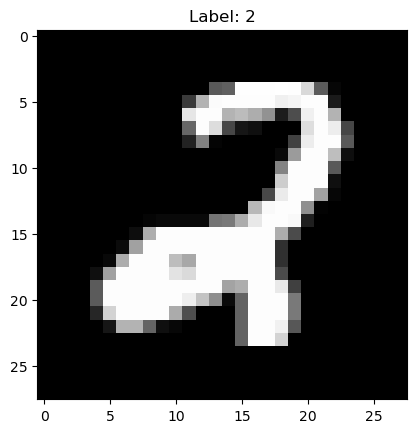

In [4]:
# test the Encoder with one MNIST image

test_image, test_label = train_dataset[325]

plt.imshow(test_image.numpy().reshape(28, 28), cmap='gray')
plt.title(f"Label: {test_label}")
plt.show()

In [5]:
# define an encoder

encoder = Encoder(input_dim = 784, hidden_dim = 400, latent_dim = 200)

# producs the mean and log-variance vectors in the latent space

test_image = test_image.view(-1,1,28 * 28)
mean, logvar = encoder.forward(test_image)

print("mean vector: ", mean.view(-1).tolist())
print("log variance vector: ", logvar.view(-1).tolist())

mean vector:  [0.001290012151002884, 0.04784742742776871, -0.015359390527009964, 0.05823418125510216, -0.01650475710630417, -0.09122452139854431, 0.07912745326757431, 0.01632765308022499]
log variance vector:  [0.7226942181587219, 0.6970947980880737, 0.7146450281143188, 0.6719948649406433, 0.7367678284645081, 0.6916119456291199, 0.7168433666229248, 0.6932991743087769]


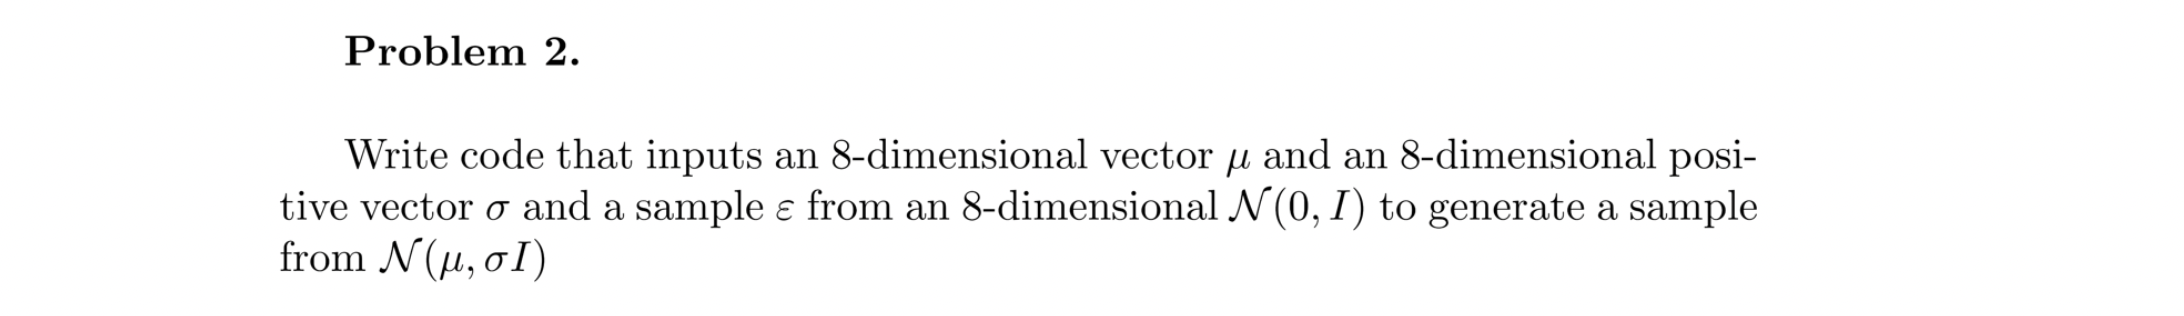

In [6]:
def reparametrize(mean, var):

    epsilon = torch.randn_like(var)
    z = mean + torch.sqrt(var) * epsilon
    
    return z

In [7]:
# test the reparametrize function

u = reparametrize(mean, torch.exp(logvar))
print("one sample from the latent space distribution: ", u.view(-1).tolist())
u = reparametrize(mean, torch.exp(logvar))
print("another sample from the latent space distribution: ", u.view(-1).tolist())

one sample from the latent space distribution:  [1.2356183528900146, 1.8548496961593628, -0.7932496070861816, -0.1599758118391037, 2.0963709354400635, 0.15477289259433746, -1.2387263774871826, 0.5813106298446655]
another sample from the latent space distribution:  [-0.33723506331443787, -1.4569981098175049, 1.6762009859085083, -1.9870741367340088, -2.771228075027466, 0.5597420930862427, 2.0333633422851562, 1.6785049438476562]


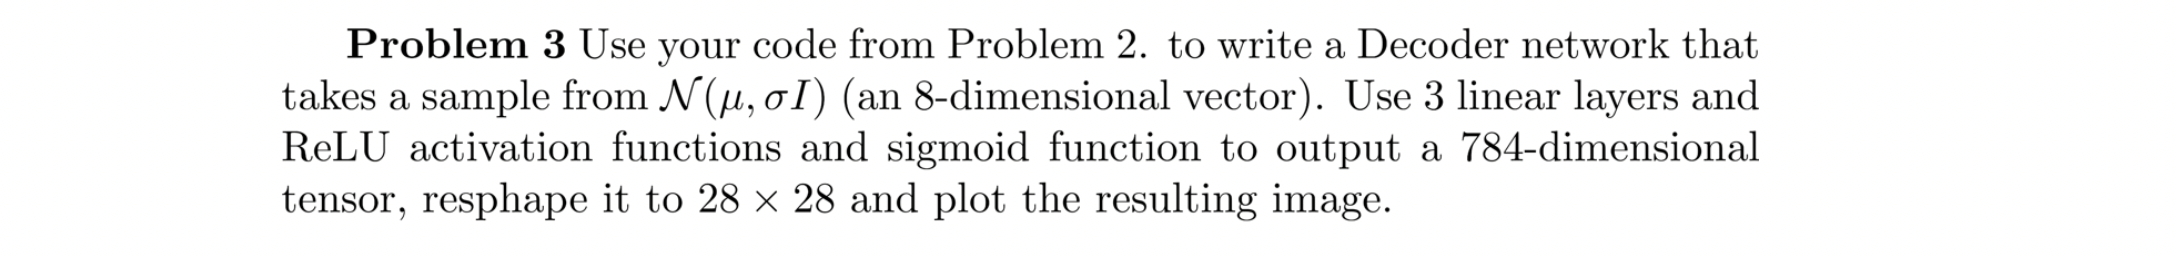

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dim, hidden_dim, input_dim):

        super().__init__()

        # 3 linear layers
        
        self.fc1 = nn.Linear(8, latent_dim)     # 8-dimensional
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, u):
        
        u = self.fc1(u)
        u = F.relu(u)   # ReLU

        u = self.fc2(u)
        u = F.relu(u)

        u = self.fc3(u)
        
        z = F.sigmoid(u).to(torch.float)  # Sigmoid
        
        return z

In [9]:
u_sample = reparametrize(mean, torch.exp(logvar))

decoder = Decoder(input_dim = 784, hidden_dim = 400, latent_dim = 200)
z = decoder.forward(u_sample)

The Encoder and Decoder are not trained yet, as a result, the output image is very different from the original input test image.

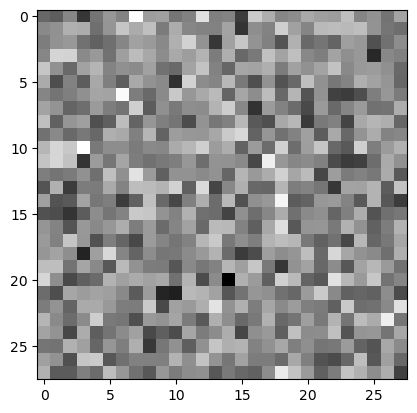

In [10]:
plt.imshow(z.detach().numpy().reshape(28, 28), cmap='gray')
plt.show()

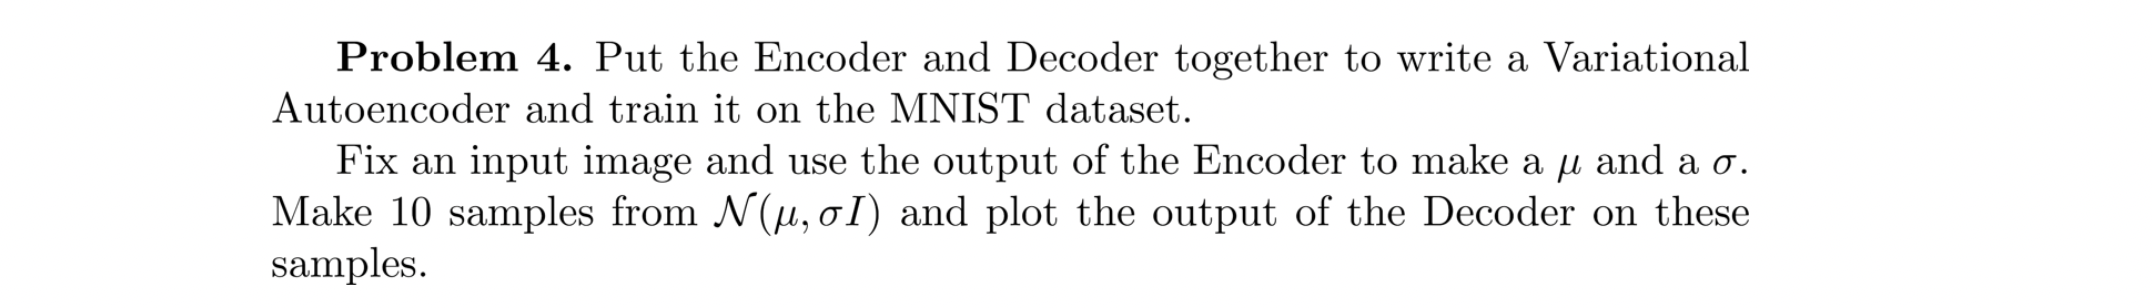

In [11]:
class VAE(nn.Module):
    
    def __init__(self, input_dim = 784, hidden_dim = 400, latent_dim = 200):

        super().__init__()
        
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
        
    def reparametrize(self, mean, var):

        epsilon = torch.randn_like(var)
        z = mean + torch.sqrt(var) * epsilon

        return z
    
    def forward(self, x):
        
        mean, logvar = self.encoder(x)
        
        u = self.reparametrize(mean, torch.exp(logvar))
        z = self.decoder(u)
        
        return z, mean, logvar    


def loss_function(x, z, mean, logvar):

    reconstruction_loss = F.binary_cross_entropy(z, x, reduction='sum')
    KL_div =  - 0.5 * torch.sum(1+ logvar - mean**2 - torch.exp(logvar))
    
    return reconstruction_loss + KL_div    

In [12]:
# train the Variational Autoencoder on the MNIST dataset

def training(model, train_loader, lr, epochs):

    optimizer = Adam(vae.parameters(), lr = lr)
    average_loss_list = []

    for e in tqdm(range(epochs)):

        overall_loss = 0.0

        for i,img in enumerate(train_loader):
            
            x = img[0].reshape(-1, 28*28)

            z,mean,logvar = vae(x)
            
            optimizer.zero_grad()

            loss = loss_function(x, z, mean,logvar)
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        # print("\tEpoch", e + 1, "\tAverage Loss: ", overall_loss/(i*batch_size))
        average_loss_list.append(overall_loss/(i*batch_size))

    return model, average_loss_list

In [14]:
vae = VAE()
vae, average_loss = training(vae, train_loader, lr = 1e-3, epochs = 50)

100%|██████████| 50/50 [10:06<00:00, 12.12s/it]


In [15]:
def plot_losses(losses):

    plt.figure(figsize = (20,6), dpi = 100).set_facecolor('white')
    plt.plot(losses)

    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    # plt.yscale('log')

    plt.title('Average of Loss for Training VAE')

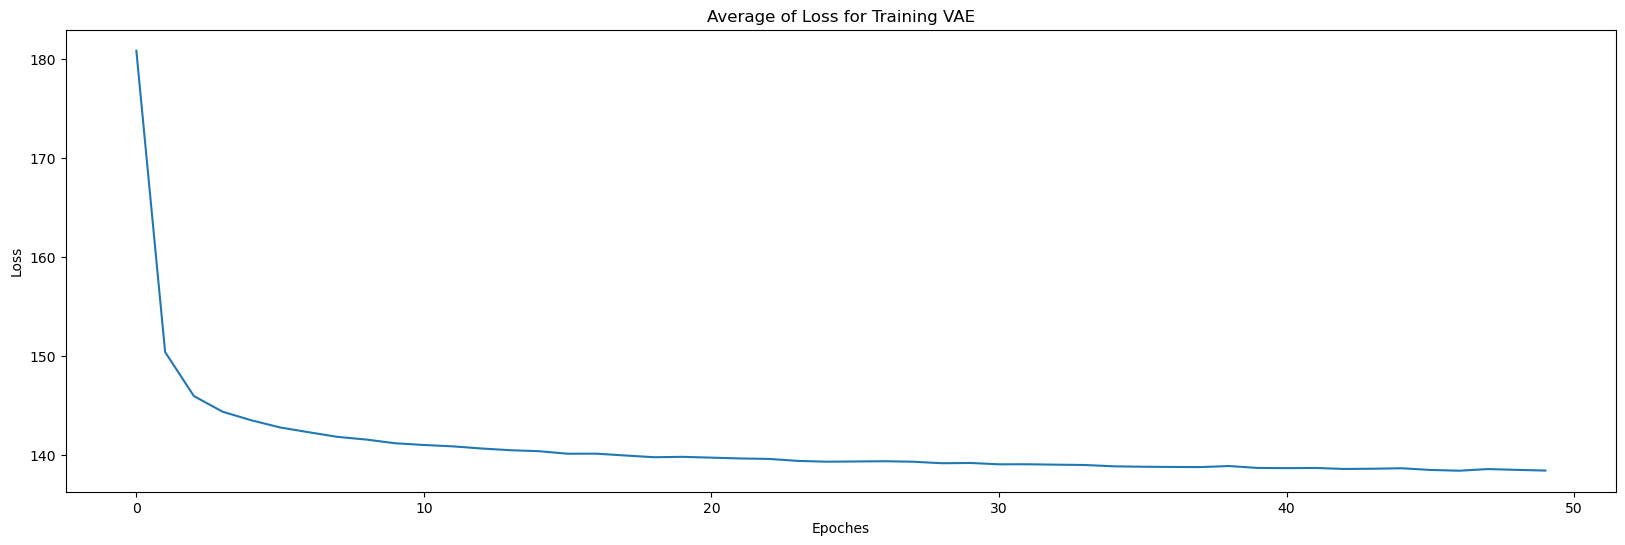

In [16]:
plot_losses(average_loss)

In [17]:
vae.eval()

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=200, bias=True)
    (mean_layer): Linear(in_features=200, out_features=8, bias=True)
    (logvar_layer): Linear(in_features=200, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=400, bias=True)
    (fc3): Linear(in_features=400, out_features=784, bias=True)
  )
)

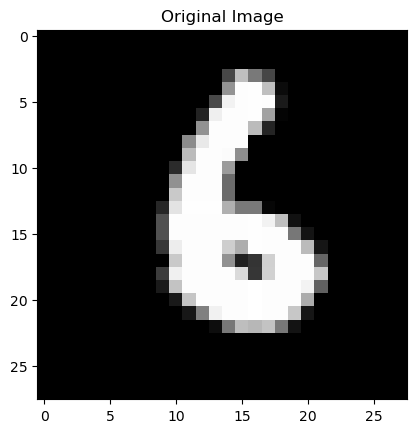

In [18]:
# fix an input image

test_batch = next(iter(test_loader))
test_image = test_batch[0][36]

plt.imshow(test_image.numpy().reshape(28, 28), cmap='gray')
plt.title("Original Image")
plt.show()

In [19]:
# use the fixed image to make mean and log variance vectors

test_image = test_image.reshape(1, 1, 28*28)
test_hat, test_mean, test_logvar = vae(test_image)

print("mean vector: ", test_mean.view(-1).tolist())
print("log variance vector: ", test_logvar.view(-1).tolist())

mean vector:  [-5.0997796058654785, 1.2396090030670166, -0.447070449590683, 3.8245339393615723, 0.43862366676330566, 0.474822998046875, 2.096956968307495, 2.198732852935791]
log variance vector:  [4.723056399706717e-22, 1.3056244360252092e-23, 3.226818177866634e-24, 4.3383692627999045e-23, 4.446593090387175e-22, 9.408079006827906e-24, 5.214542744514843e-22, 1.2481718225157078e-22]


In [20]:
# make 10 samples from the learned latent space

num_sample = 10

epsilon = torch.randn(num_sample, 8)
latent_samples = test_mean + epsilon * torch.exp(test_logvar)

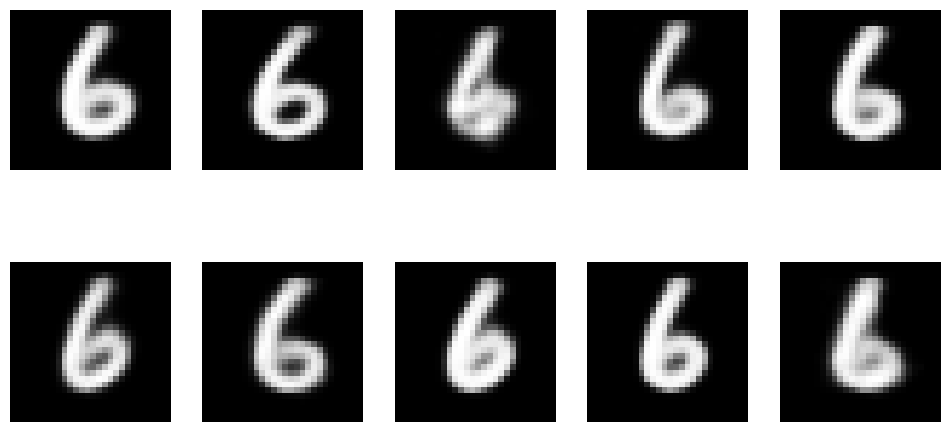

In [21]:
# plot the output of the Decoder on these samples

output_imgs = vae.decoder(latent_samples).detach()
output_imgs = output_imgs.reshape(10,28,28)

plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(output_imgs[i], cmap='gray')
    plt.axis('off')

plt.show()